In [20]:
import seaborn as sns
import folium
import geopandas as gpd
import pandas as pd
from logging import warning

from utils.downloads import (
    Censo,
    Nivel,
    download_malha
)

In [21]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Índice de impureza de Gini

O índice de impureza de Gini (em homenagem ao matemático italiano Corrado Gini) é uma medida de quantas vezes um elemento escolhido aleatoriamente do conjunto seria rotulado incorretamente se fosse rotulado aleatoriamente de acordo com o distribuição de rótulos no subconjunto.

A impureza Gini pode ser calculada somando a probabilidade $p_{j}$ de um item com etiqueta $j$ ser escolhido vezes a probabilidade $\sum _{k\neq j}p_{k}=1-p_{j}$ de um erro na categorização desse item.

Ele atinge seu mínimo (zero) quando todos os casos no nó caem em uma única categoria de destino.

Para calcular a impureza Gini para um conjunto de itens com $J$ classes, suponha $j\in \{1,2,...,J\}$, e considere a fração $p_{j}$ de itens rotulados com classe $j$ no conjunto.

$$ \text{I}_{G}(p)=\sum _{j=1}^{J}\left(p_{j}\sum_{k\neq j}p_{k}\right)=\sum_{j=1}^{J}p_{j}(1-p_{j})=\sum_{j=1}^{J}(p_{j}-{p_{j}}^{2})=\sum_{j=1}^{J}p_{j}-\sum_{j=1}^{J}{p_{j}}^{2}=1-\sum_{j=1}^{J}{p_{j}}^{2}$$


Adaptando ao nosso contexto, consideramos que cada setor censitário de 2022 é composto por $J$ setores censitários de 2010, e que a probabilidade de classificação correta $p_j$ seja equivalente à similaridade do setor censitário de 2022 e um dado setor censitário de 2010.and

Assim, conseguimos avaliar a impureza de cada um dos setores censitários de 2022 com base na sua composição.


Além disso, podemos utilizar o índice de impureza de Gini como métrica para avaliar o ganho de qualidade nos dados relativo a cada um dos tratamentos realizados.

# Carregando os dados

Primeiro, vamos carregar os dados básicos dos setores censitários de 2022 e os dados de similaridade gerados nos notebooks anteriores.

In [22]:
%%time
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

CPU times: user 20.1 s, sys: 1.32 s, total: 21.4 s
Wall time: 55.8 s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
59701,125226.0,355030882000052,URBANO,35503088200,None,355030882,TUCURUVI,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,59702,"POLYGON ((337309.414 7402407.569, 337291.181 7..."
42339,109953.0,355030811000044,URBANO,35503081100,None,355030811,BRASILÂNDIA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42340,"POLYGON ((327716.432 7403640.701, 327722.914 7..."
42364,110104.0,355030811000195,URBANO,35503081100,None,355030811,BRASILÂNDIA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42365,"POLYGON ((325506.070 7404459.678, 325503.004 7..."


In [23]:
%%time
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES)
setores22 = setores22[setores22['CD_MUN'] == '3550308']
setores22 = setores22.to_crs(epsg=31983)
setores22.sample(3)

CPU times: user 1min 4s, sys: 968 ms, total: 1min 5s
Wall time: 1min 14s


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
85815,355030868000644P,0.009573,3,Sudeste,35,São Paulo,3550308,São Paulo,355030868,Sacomã,...,3550308,São Paulo/SP,583,203,203,0,2.959391,17.766497,197,"POLYGON ((337523.564 7387624.878, 337529.675 7..."
82907,355030859000274P,0.022960,3,Sudeste,35,São Paulo,3550308,São Paulo,355030859,Penha,...,3550308,São Paulo/SP,355,169,169,0,2.482517,12.587413,143,"POLYGON ((343704.931 7397662.452, 343701.113 7..."
89816,355030883000138P,0.004760,3,Sudeste,35,São Paulo,3550308,São Paulo,355030883,Vila Andrade,...,3550308,São Paulo/SP,393,182,182,0,2.339286,8.928571,168,"POLYGON ((323011.738 7384794.954, 322965.480 7..."


In [24]:
sim_10_path = 'data/01_similarity_10.parquet'
sim_10 = gpd.read_parquet(sim_10_path)
sim_10

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
0,355030801000001P,355030801000001,"POLYGON ((339811.471 7392866.307, 339812.545 7...",70930.590833,9.833295e-01
1,355030801000001P,355030801000006,"MULTIPOLYGON (((339784.892 7392592.542, 339819...",373.279509,3.782129e-03
2,355030801000001P,355030801000010,"POLYGON ((339456.132 7392739.111, 339531.109 7...",9.240690,1.543379e-04
3,355030801000001P,355030801000011,"POLYGON ((339661.597 7392807.484, 339808.953 7...",471.770933,8.274765e-03
4,355030801000002P,355030801000001,"POLYGON ((339810.127 7392984.872, 339814.260 7...",18.451154,2.557932e-04
...,...,...,...,...,...
114396,355030896000338P,355030896000104,"POLYGON ((355815.970 7397540.784, 355573.189 7...",33668.997801,7.866150e-01
114397,355030896000339P,355030884000164,"POLYGON ((355931.532 7397554.886, 355953.783 7...",0.003980,1.136118e-07
114398,355030896000339P,355030896000044,"MULTIPOLYGON (((355937.670 7397481.306, 355952...",2.775304,4.792580e-05
114399,355030896000339P,355030896000103,"MULTIPOLYGON (((355825.873 7397538.347, 355877...",6952.030517,1.608160e-01


In [25]:
sim_viario_10_path = 'data/02_similarity_viario_10.parquet'
sim_viario_10 = gpd.read_parquet(sim_viario_10_path)
sim_viario_10

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
0,355030801000001P,355030801000001,"MULTIPOLYGON (((339806.356 7392596.796, 339779...",60142.847118,9.960823e-01
1,355030801000001P,355030801000006,"POLYGON ((339708.368 7392605.968, 339707.507 7...",47.562187,6.429313e-04
2,355030801000002P,355030801000002,"MULTIPOLYGON (((339956.877 7392696.391, 339946...",61038.586717,9.960391e-01
3,355030801000002P,355030801000004,"MULTIPOLYGON (((339897.400 7392679.461, 339888...",504.763397,8.958203e-03
4,355030801000003P,355030801000002,"MULTIPOLYGON (((339915.684 7392696.058, 339916...",242.683018,3.960147e-03
...,...,...,...,...,...
87836,355030896000338P,355030896000103,"MULTIPOLYGON (((355571.342 7397652.973, 355572...",122.522044,3.361404e-03
87837,355030896000338P,355030896000104,"MULTIPOLYGON (((355712.152 7397608.612, 355714...",26629.910122,7.573375e-01
87838,355030896000339P,355030896000044,"POLYGON ((355967.757 7397511.604, 355968.423 7...",0.000118,2.325016e-09
87839,355030896000339P,355030896000103,"MULTIPOLYGON (((355805.446 7397532.150, 355816...",5789.638008,1.588393e-01


In [26]:
sim_double_buff_10_path = 'data/06_similarity_double_buffer_10.parquet'
sim_double_buff_10 = gpd.read_parquet(sim_double_buff_10_path)
sim_double_buff_10

,CD_GEOCODI,CD_SETOR,geometry,inter_area,inter_perc
66320,355030804000079,355030804000079P,"MULTIPOLYGON (((345004.253 7391489.517, 345004...",27868.809593,1.000000
66321,355030804000080,355030804000080P,"MULTIPOLYGON (((344747.028 7391454.176, 344885...",29099.528367,1.000000
66322,355030804000081,355030804000081P,"MULTIPOLYGON (((344686.207 7391268.311, 344688...",17257.656772,1.000000
66321,355030804000082,355030804000080P,"POLYGON ((344743.884 7391449.027, 344742.477 7...",3.674850,0.000137
66323,355030804000082,355030804000082P,"MULTIPOLYGON (((344737.762 7391446.652, 344737...",26889.176795,0.999863
...,...,...,...,...,...
93242,355030896000246,355030896000227P,"POLYGON ((354771.973 7397966.378, 354814.526 7...",147.748258,0.025620
93260,355030896000246,355030896000245P,"POLYGON ((354771.670 7397970.756, 354750.848 7...",1669.246568,0.289455
93261,355030896000246,355030896000246P,"POLYGON ((354784.574 7397992.486, 354788.166 7...",3949.865171,0.684925
93212,355030896000247,355030896000193P,"POLYGON ((357430.206 7395524.645, 357430.202 7...",980.495123,0.096088


In [27]:
sim_double_buff_resga_10_path = 'data/06_similarity_double_buffer_resga_10.parquet'
sim_double_buff_resga_10 = gpd.read_parquet(sim_double_buff_resga_10_path)
sim_double_buff_resga_10

,CD_GEOCODI,CD_SETOR,geometry,inter_area,inter_perc
557,355030804000079,355030804000079P,"MULTIPOLYGON (((344923.185 7391231.361, 344925...",27868.809593,1.000000
558,355030804000080,355030804000080P,"MULTIPOLYGON (((344852.331 7391245.510, 344855...",29099.528367,1.000000
559,355030804000081,355030804000081P,"MULTIPOLYGON (((344688.119 7391274.180, 344692...",17257.656772,1.000000
558,355030804000082,355030804000080P,"POLYGON ((344742.196 7391443.694, 344742.081 7...",3.674850,0.000137
560,355030804000082,355030804000082P,"MULTIPOLYGON (((344643.686 7391295.269, 344650...",26889.176795,0.999863
...,...,...,...,...,...
27476,355030896000246,355030896000227P,"POLYGON ((354771.973 7397966.378, 354814.526 7...",147.748258,0.025620
27494,355030896000246,355030896000245P,"POLYGON ((354750.848 7397978.475, 354780.511 7...",1669.246568,0.289455
27495,355030896000246,355030896000246P,"POLYGON ((354784.574 7397992.486, 354788.166 7...",3949.865171,0.684925
27446,355030896000247,355030896000193P,"POLYGON ((357430.206 7395524.645, 357430.202 7...",980.495123,0.096088


In [28]:
%%time
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES)
setores10 = setores10[setores10['CD_GEOCODM'] == '3550308']
setores10 = setores10.to_crs(epsg=31983)
setores10.sample(3)

CPU times: user 18.3 s, sys: 402 ms, total: 18.7 s
Wall time: 19 s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
57614,123109.0,355030871000056,URBANO,35503087100,None,355030871,SANTO AMARO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,57615,"POLYGON ((328969.036 7384730.171, 328968.916 7..."
55223,120762.0,355030860000062,URBANO,35503086000,None,355030860,PERDIZES,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,55224,"POLYGON ((327818.959 7396518.588, 327828.936 7..."
46798,112338.0,355030822000076,URBANO,35503082200,None,355030822,CIDADE ADEMAR,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,46799,"POLYGON ((331633.191 7381174.725, 331629.106 7..."


# Calculando o índice

In [29]:
def gini_impurity(df:pd.DataFrame, prob_col:str='inter_perc', precision:int=5) -> float:
    prob_sum = round(df[prob_col].sum(), precision)
    if prob_sum != 1:
        warning(f'A soma das probabilidades do setor {df.iloc[0,1]} ({prob_sum}) é diferente de 1')
        if df.shape[0]==1:
            warning('Como ele possui interseção com apenas um setor, sua impureza foi arrendodada para 0')
            return 0
    return round(1-(df[prob_col]**2).sum(), precision)

In [30]:
def row_gini_impurity(row_id:str, other_df:gpd.GeoDataFrame, id_col:str='CD_GEOCODI', prob_col:str='inter_perc', precision:int=5) -> float:
    filtered_df = other_df.query(f'{id_col} == "{row_id}"')
    if filtered_df.shape[0] < 1:
        warning(f'O setor {row_id} não possui similaridade com nenhum setor de 2010')
        return 0
    return gini_impurity(filtered_df, prob_col, precision)    

In [37]:
%%time
setores10['Gini_base'] = setores10['CD_GEOCODI'].apply(lambda r: row_gini_impurity(r, sim_10))
setores10

CPU times: user 1min 7s, sys: 149 ms, total: 1min 7s
Wall time: 1min 7s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,Gini_V,Gini_DB,Gini_DBR,Gini_base
42322,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",0.02411,0.00000,0.00000,0.07977
42323,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",0.02844,0.00000,0.00000,0.06888
42324,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",0.03530,0.00000,0.00000,0.09688
42325,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",0.02249,0.00027,0.00027,0.07146
42326,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",0.04288,0.01035,0.01035,0.08122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62380,127887.0,355030896000243,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62381,"POLYGON ((358268.787 7395588.352, 358268.890 7...",0.23819,0.24519,0.24519,0.24978
62381,127888.0,355030896000244,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62382,"POLYGON ((358313.360 7395445.153, 358314.059 7...",0.03624,0.00094,0.00000,0.10133
62382,127889.0,355030896000245,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62383,"POLYGON ((354659.873 7398106.775, 354681.908 7...",0.00000,0.00000,0.00000,0.00001
62383,127890.0,355030896000246,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62384,"POLYGON ((354783.894 7398060.275, 354817.724 7...",0.48294,0.44644,0.44644,0.46890


In [38]:
%%time
setores10['Gini_V'] = setores10['CD_GEOCODI'].apply(lambda r: row_gini_impurity(r, sim_viario_10))
setores10

CPU times: user 58.5 s, sys: 320 ms, total: 58.8 s
Wall time: 58.9 s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,Gini_V,Gini_DB,Gini_DBR,Gini_base
42322,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",0.02411,0.00000,0.00000,0.07977
42323,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",0.02844,0.00000,0.00000,0.06888
42324,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",0.03530,0.00000,0.00000,0.09688
42325,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",0.02249,0.00027,0.00027,0.07146
42326,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",0.04288,0.01035,0.01035,0.08122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62380,127887.0,355030896000243,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62381,"POLYGON ((358268.787 7395588.352, 358268.890 7...",0.23819,0.24519,0.24519,0.24978
62381,127888.0,355030896000244,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62382,"POLYGON ((358313.360 7395445.153, 358314.059 7...",0.03624,0.00094,0.00000,0.10133
62382,127889.0,355030896000245,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62383,"POLYGON ((354659.873 7398106.775, 354681.908 7...",0.00000,0.00000,0.00000,0.00001
62383,127890.0,355030896000246,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62384,"POLYGON ((354783.894 7398060.275, 354817.724 7...",0.48294,0.44644,0.44644,0.46890


In [39]:
%%time
setores10['Gini_DB'] = setores10['CD_GEOCODI'].apply(lambda r: row_gini_impurity(r, sim_double_buff_10))
setores10

CPU times: user 43.2 s, sys: 92.7 ms, total: 43.3 s
Wall time: 43.3 s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,Gini_V,Gini_DB,Gini_DBR,Gini_base
42322,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",0.02411,0.00000,0.00000,0.07977
42323,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",0.02844,0.00000,0.00000,0.06888
42324,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",0.03530,0.00000,0.00000,0.09688
42325,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",0.02249,0.00027,0.00027,0.07146
42326,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",0.04288,0.01035,0.01035,0.08122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62380,127887.0,355030896000243,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62381,"POLYGON ((358268.787 7395588.352, 358268.890 7...",0.23819,0.24519,0.24519,0.24978
62381,127888.0,355030896000244,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62382,"POLYGON ((358313.360 7395445.153, 358314.059 7...",0.03624,0.00094,0.00000,0.10133
62382,127889.0,355030896000245,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62383,"POLYGON ((354659.873 7398106.775, 354681.908 7...",0.00000,0.00000,0.00000,0.00001
62383,127890.0,355030896000246,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62384,"POLYGON ((354783.894 7398060.275, 354817.724 7...",0.48294,0.44644,0.44644,0.46890


In [40]:
%%time
setores10['Gini_DBR'] = setores10['CD_GEOCODI'].apply(lambda r: row_gini_impurity(r, sim_double_buff_resga_10))
setores10

CPU times: user 45.4 s, sys: 90.6 ms, total: 45.5 s
Wall time: 45.5 s


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry,Gini_V,Gini_DB,Gini_DBR,Gini_base
42322,109347.0,355030804000079,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42323,"POLYGON ((345114.562 7391509.505, 345106.759 7...",0.02411,0.00000,0.00000,0.07977
42323,109348.0,355030804000080,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42324,"POLYGON ((345002.927 7391486.947, 344983.085 7...",0.02844,0.00000,0.00000,0.06888
42324,109349.0,355030804000081,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42325,"POLYGON ((344874.928 7391332.868, 344864.237 7...",0.03530,0.00000,0.00000,0.09688
42325,109350.0,355030804000082,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42326,"POLYGON ((344746.124 7391456.534, 344742.477 7...",0.02249,0.00027,0.00027,0.07146
42326,109351.0,355030804000083,URBANO,35503080400,None,355030804,ARICANDUVA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,42327,"POLYGON ((344512.429 7391240.196, 344500.243 7...",0.04288,0.01035,0.01035,0.08122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62380,127887.0,355030896000243,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62381,"POLYGON ((358268.787 7395588.352, 358268.890 7...",0.23819,0.24519,0.24519,0.24978
62381,127888.0,355030896000244,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62382,"POLYGON ((358313.360 7395445.153, 358314.059 7...",0.03624,0.00094,0.00000,0.10133
62382,127889.0,355030896000245,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62383,"POLYGON ((354659.873 7398106.775, 354681.908 7...",0.00000,0.00000,0.00000,0.00001
62383,127890.0,355030896000246,URBANO,35503089600,None,355030896,LAJEADO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,62384,"POLYGON ((354783.894 7398060.275, 354817.724 7...",0.48294,0.44644,0.44644,0.46890


# Análise comparada dos índices

In [41]:
setores10[['Gini_base', 'Gini_V', 'Gini_DB', 'Gini_DBR']].describe()

,Gini_base,Gini_V,Gini_DB,Gini_DBR
count,18953.000000,18953.000000,18953.000000,18953.00000
mean,0.215744,0.205226,0.195083,0.19508
std,0.242888,0.244693,0.243790,0.24379
min,0.000000,0.000000,0.000000,0.00000
25%,0.000660,0.000060,0.000000,0.00000
50%,0.088540,0.046310,0.019160,0.01916
75%,0.461570,0.455550,0.446280,0.44628
max,0.929850,0.929510,0.928760,0.92876


No geral, as distribuições tiveram poucas mudanças, com a média e o desvio padrão bastante próximos.

Porém, as mudanças no Q3 e, no caso do Gini de base, na mediana se mostram bastante importantes.

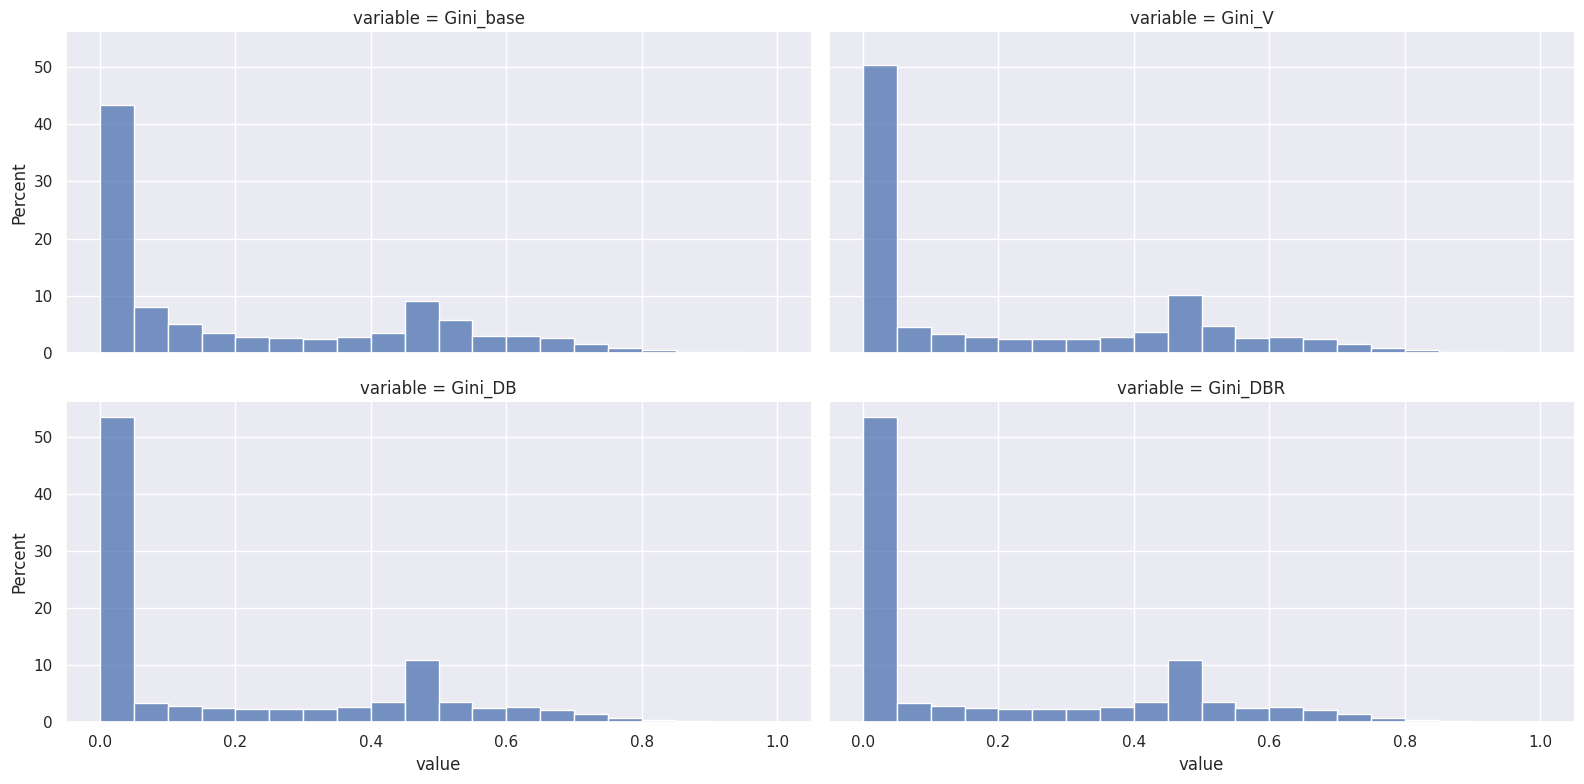

In [42]:
melted = setores10[['CD_GEOCODI', 'Gini_base', 'Gini_V', 'Gini_DB', 'Gini_DBR']].melt('CD_GEOCODI')
g = sns.FacetGrid(melted,
                  col="variable",
                  col_wrap=2,
                  height=4,
                  aspect=2)
g.map(sns.histplot, "value", stat='percent', bins=[b/100 for b in range(0, 105, 5)])


Os histogramas também corroboram com as impressões anteriores: as distribuições mantiveram seu formato geral semelhante, mas com uma redução dos valores acima de 0,5.

Também é expressiva a redução de valores entre 0,05 e 1, o que indica que esses setores provavelmente puderam ter sua impureza reduzida a 0.

# Apresentação visual dos índices

In [44]:
indexes = [
    ('Gini (Base)', 'Gini_base'),
    ('Gini 2010 (Recorte viário)', 'Gini_V'),
    ('Gini 2010 (Recorte viário + Buffers)', 'Gini_DB'),
    ('Gini 2010 (Recorte viário + Buffers + Exclusão de resgas)', 'Gini_DBR')
]

In [48]:
def save_folium_map(label:str, col:str) -> None:
    gini_map = setores22.explore(
        tiles='CartoDB positron',
        name='Setores (2022)',  # name of the layer in the map
        color='royalblue',
        style_kwds={'fill': False, 'weight': 1},
    )
    
    gini_map = setores10.explore(
        m=gini_map,
        column=col,
        # scheme='Quantiles',
        cmap='RdYlGn_r',
        linewidth=0.01,
        legend=True,
        k=10, 
        tooltip=True,
        legend_kwds=dict(colorbar=True, scale=False),  # do not use colorbar
        # legend_kwds=dict(colorbar=False),
        style_kwds={'weight': 1},
        name=label,
    )
    
    folium.LayerControl().add_to(gini_map)  # use folium to add layer control
    
    gini_map.save(f'plots/{col}.html')

In [50]:
for i in indexes:
    save_folium_map(*i)

In [49]:
i_label, i_col = indexes[2]

save_folium_map(*indexes[0])

# gini_map = setores10.plot(
#     column=i_col,
#     scheme="equal_interval",
#     k=10,
#     cmap="RdYlGn_r",
#     # edgecolor="k",
#     linewidth=0.01,
#     legend=True,
#     legend_kwds={"loc": "lower right"},
#     figsize=(14,17)
# )

# Efeito colateral não previsto: setores censitários de 2022 "sem similaridade"

Alguns setores censitários de 2022, com variações em cada tipo de tratamento, não apresentaram similaridade com nenhum setor censitário de 2010 (o que causa estranhamento, visto que as dimensões do município se mantiveram).

Para entender melhor, vamos analisar esses setores.

In [ ]:
inter_by_setor = sim_double_buff_10.groupby('CD_GEOCODI').count()
setores10['intersections'] = setores10['CD_GEOCODI'].apply(lambda i: 0 if i not in inter_by_setor.index else inter_by_setor.loc[i, 'CD_GEOCODI'])
setores10

In [ ]:
setores10.query('intersections < 1')

In [ ]:
setores10['debuff'] = setores10.buffer(-2)

In [ ]:
dists = setores10.query('intersections < 1').query('v0001 != "0"').loc[:, 'CD_DIST'].unique()

if len(dists) > 0:
    m = setores10.query('CD_GEOCODD in @dists').explore(
        name='Setores (2010)',  # name of the layer in the map
        color='darkred',
    )
    
    m = setores10.query('intersections < 1').query('v0001 != "0"').explore(
        m=m,
        name='Setores sem similaridade',
        color='royalblue',
        style_kwds={'fill': False},
    )
    
    m = setores10.query('intersections < 1').query('v0001 != "0"').debuff.explore(
        m=m,
        name='Setores sem similaridade',
        color='lightblue',
        style_kwds={'fill': False},
    )
    
    m

In [ ]:
setores10.query('CD_SETOR == "355030825000340P"')

In [ ]:
dists = setores10.query('CD_SETOR == "355030825000340P"').loc[:, 'CD_DIST'].unique()

n = setores10.query('CD_GEOCODD in @dists').explore(
    name='Setores (2010)',  # name of the layer in the map
    color='darkred',
)

n = setores10.query('CD_SETOR == "355030825000340P"').explore(
    m=n,
    name='Setores sem similaridade',
    color='royalblue',
    style_kwds={'fill': False},
)

n = setores10.query('CD_SETOR == "355030825000340P"').debuff.explore(
    m=n,
    name='Setores sem similaridade',
    color='lightblue',
    style_kwds={'fill': False},
)

n